# Detect hapiness 

This notebook is based on the programming assignment of deeplearning.ai, course Convolutional Neural Networks, week Deep convolutional models case studies

We will build an algorithm that recognizes whether the person in a picture is happy or not.

## Learning objectives

- Application of Convolutional Neural Networks in TensorFlow
- Apply Batch Normalization
- Use of Adam optimizer 
- Use of GPU for the training of the model

In [2]:
import numpy as np
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import time
import math
import h5py
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

1.14.0


In [3]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [4]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [6]:
def build_inputs():
    
    inputs_ = tf.placeholder(tf.float32,[None,64,64,3],name='inputs_')
    targets_ = tf.placeholder(tf.float32,[None,1], name='targets_')
    training = tf.placeholder_with_default(False, shape=(), name='training')
    
    return inputs_, targets_, training

In [7]:
def build_loss(logits, targets):
        
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))

    return loss

In [8]:
def build_optimizer(loss, learning_rate):
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

In [9]:
class HappyModel:
    
    def __init__(self, learning_rate):
    
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs_, self.targets_, self.training = build_inputs()
        
        # Zero-Padding
        paddings = tf.constant([[0, 0], [3, 3,], [3, 3], [0, 0]])
        self.X = tf.pad(self.inputs_, paddings, "CONSTANT")
        
        # CONV -> BN -> RELU Block applied to X
        strides = 1        
        self.X = tf.layers.conv2d(self.X, 32, kernel_size = [7, 7], strides = [strides, strides],
                             padding='VALID',name = 'conv0')
        self.X = tf.layers.batch_normalization(self.X, training=self.training, name = 'bn0')
        self.X = tf.nn.relu(self.X)
        
        # MAXPOOL
        self.X = tf.nn.max_pool(self.X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
        self.X = tf.contrib.layers.flatten(self.X)
        self.X = tf.contrib.layers.fully_connected(self.X, 1, activation_fn=None)
        self.prediction = tf.nn.sigmoid(self.X) 
        
        self.loss = build_loss(self.X, self.targets_)
        self.optimizer = build_optimizer(self.loss, learning_rate)
        
        correct_prediction = tf.equal(tf.round(self.prediction), self.targets_)
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.acc, self.acc_op = tf.metrics.accuracy(labels=self.targets_, 
                                  predictions=tf.round(self.prediction))

In [10]:
batch_size = 16
mini_batch_size = 16
learning_rate = 0.001

### Load the dataset

In [11]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.


Y_train = tf.transpose(Y_train_orig)
Y_test = tf.transpose(Y_test_orig)

with tf.Session(config=config) as sess:
    Y_train,Y_test = sess.run([Y_train,Y_test])
    
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [12]:
tf.reset_default_graph()
epochs = 80
model = HappyModel(learning_rate = learning_rate)
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

train_acc_mean = []

with tf.Session(config=config) as sess:
    saver = tf.train.Saver() 
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    #start_time=time.time()
    for e in range(epochs):
        train_acc = []
        train_acc_v2 = []
        iteration = 1
         
        for (x, y) in random_mini_batches(X_train, Y_train, mini_batch_size = mini_batch_size, seed = 0):
            feed = {model.inputs_: x,
                   model.targets_: y,
                   model.training: True}

            batch_loss, batch_accuracy, batch_acc, batch_acc_op,_, _= sess.run([model.loss, model.accuracy,
                                                      model.acc, model.acc_op,
                                                      model.optimizer ,extra_graphkeys_update_ops],
                                 feed_dict=feed)
            
            train_acc.append(batch_accuracy)
            train_acc_v2.append(batch_acc_op)
            if iteration%5==0:
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(batch_loss),
                      "Train accuracy: {:.4f}".format(batch_acc_op)
                     )
                     
                
            iteration +=1
    
    #duration=time.time()-start_time
    #print("duration: {:.1f} sec".format(duration))
        print("Train accuracy (mean): {:.4f}".format(np.mean(train_acc_v2)))
        train_acc_mean.append(np.mean(train_acc_v2))
    saver.save(sess, "checkpoints/HappyModel.ckpt")

W0812 22:38:31.030511 30984 deprecation.py:323] From <ipython-input-9-5c64e489e3d6>:17: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0812 22:38:31.033517 30984 deprecation.py:506] From C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0812 22:38:31.189118 30984 deprecation.py:323] From <ipython-input-9-5c64e489e3d6>:18: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.co

Epoch: 1/80 Iteration: 5 Train loss: 0.829 Train accuracy: 0.4750
Epoch: 1/80 Iteration: 10 Train loss: 0.575 Train accuracy: 0.6313
Epoch: 1/80 Iteration: 15 Train loss: 0.280 Train accuracy: 0.6917
Epoch: 1/80 Iteration: 20 Train loss: 0.306 Train accuracy: 0.7219
Epoch: 1/80 Iteration: 25 Train loss: 0.758 Train accuracy: 0.7250
Epoch: 1/80 Iteration: 30 Train loss: 0.070 Train accuracy: 0.7437
Epoch: 1/80 Iteration: 35 Train loss: 0.311 Train accuracy: 0.7536
Train accuracy (mean): 0.6675
Epoch: 2/80 Iteration: 5 Train loss: 0.169 Train accuracy: 0.7676
Epoch: 2/80 Iteration: 10 Train loss: 0.106 Train accuracy: 0.7750
Epoch: 2/80 Iteration: 15 Train loss: 0.163 Train accuracy: 0.7881
Epoch: 2/80 Iteration: 20 Train loss: 0.343 Train accuracy: 0.7935
Epoch: 2/80 Iteration: 25 Train loss: 0.133 Train accuracy: 0.8040
Epoch: 2/80 Iteration: 30 Train loss: 0.085 Train accuracy: 0.8148
Epoch: 2/80 Iteration: 35 Train loss: 0.139 Train accuracy: 0.8233
Train accuracy (mean): 0.7937
Epoc

Epoch: 18/80 Iteration: 5 Train loss: 0.005 Train accuracy: 0.9320
Epoch: 18/80 Iteration: 10 Train loss: 0.086 Train accuracy: 0.9322
Epoch: 18/80 Iteration: 15 Train loss: 0.018 Train accuracy: 0.9328
Epoch: 18/80 Iteration: 20 Train loss: 0.025 Train accuracy: 0.9332
Epoch: 18/80 Iteration: 25 Train loss: 0.077 Train accuracy: 0.9336
Epoch: 18/80 Iteration: 30 Train loss: 0.010 Train accuracy: 0.9338
Epoch: 18/80 Iteration: 35 Train loss: 0.002 Train accuracy: 0.9342
Train accuracy (mean): 0.9330
Epoch: 19/80 Iteration: 5 Train loss: 0.003 Train accuracy: 0.9348
Epoch: 19/80 Iteration: 10 Train loss: 0.052 Train accuracy: 0.9350
Epoch: 19/80 Iteration: 15 Train loss: 0.011 Train accuracy: 0.9355
Epoch: 19/80 Iteration: 20 Train loss: 0.026 Train accuracy: 0.9359
Epoch: 19/80 Iteration: 25 Train loss: 0.121 Train accuracy: 0.9362
Epoch: 19/80 Iteration: 30 Train loss: 0.031 Train accuracy: 0.9364
Epoch: 19/80 Iteration: 35 Train loss: 0.002 Train accuracy: 0.9368
Train accuracy (mean

Epoch: 34/80 Iteration: 30 Train loss: 0.099 Train accuracy: 0.9564
Epoch: 34/80 Iteration: 35 Train loss: 0.001 Train accuracy: 0.9565
Train accuracy (mean): 0.9561
Epoch: 35/80 Iteration: 5 Train loss: 0.001 Train accuracy: 0.9567
Epoch: 35/80 Iteration: 10 Train loss: 0.044 Train accuracy: 0.9568
Epoch: 35/80 Iteration: 15 Train loss: 0.004 Train accuracy: 0.9569
Epoch: 35/80 Iteration: 20 Train loss: 0.007 Train accuracy: 0.9569
Epoch: 35/80 Iteration: 25 Train loss: 0.022 Train accuracy: 0.9571
Epoch: 35/80 Iteration: 30 Train loss: 0.013 Train accuracy: 0.9572
Epoch: 35/80 Iteration: 35 Train loss: 0.002 Train accuracy: 0.9573
Train accuracy (mean): 0.9570
Epoch: 36/80 Iteration: 5 Train loss: 0.001 Train accuracy: 0.9575
Epoch: 36/80 Iteration: 10 Train loss: 0.016 Train accuracy: 0.9576
Epoch: 36/80 Iteration: 15 Train loss: 0.000 Train accuracy: 0.9578
Epoch: 36/80 Iteration: 20 Train loss: 0.006 Train accuracy: 0.9579
Epoch: 36/80 Iteration: 25 Train loss: 0.002 Train accurac

Epoch: 51/80 Iteration: 5 Train loss: 0.003 Train accuracy: 0.9661
Epoch: 51/80 Iteration: 10 Train loss: 0.018 Train accuracy: 0.9661
Epoch: 51/80 Iteration: 15 Train loss: 0.000 Train accuracy: 0.9662
Epoch: 51/80 Iteration: 20 Train loss: 0.020 Train accuracy: 0.9663
Epoch: 51/80 Iteration: 25 Train loss: 0.000 Train accuracy: 0.9663
Epoch: 51/80 Iteration: 30 Train loss: 0.138 Train accuracy: 0.9663
Epoch: 51/80 Iteration: 35 Train loss: 0.005 Train accuracy: 0.9664
Train accuracy (mean): 0.9663
Epoch: 52/80 Iteration: 5 Train loss: 0.000 Train accuracy: 0.9665
Epoch: 52/80 Iteration: 10 Train loss: 0.006 Train accuracy: 0.9666
Epoch: 52/80 Iteration: 15 Train loss: 0.000 Train accuracy: 0.9667
Epoch: 52/80 Iteration: 20 Train loss: 0.009 Train accuracy: 0.9668
Epoch: 52/80 Iteration: 25 Train loss: 0.000 Train accuracy: 0.9668
Epoch: 52/80 Iteration: 30 Train loss: 0.000 Train accuracy: 0.9669
Epoch: 52/80 Iteration: 35 Train loss: 0.000 Train accuracy: 0.9670
Train accuracy (mean

Epoch: 67/80 Iteration: 30 Train loss: 0.005 Train accuracy: 0.9714
Epoch: 67/80 Iteration: 35 Train loss: 0.020 Train accuracy: 0.9714
Train accuracy (mean): 0.9713
Epoch: 68/80 Iteration: 5 Train loss: 0.001 Train accuracy: 0.9714
Epoch: 68/80 Iteration: 10 Train loss: 0.007 Train accuracy: 0.9714
Epoch: 68/80 Iteration: 15 Train loss: 0.000 Train accuracy: 0.9714
Epoch: 68/80 Iteration: 20 Train loss: 0.002 Train accuracy: 0.9715
Epoch: 68/80 Iteration: 25 Train loss: 0.003 Train accuracy: 0.9716
Epoch: 68/80 Iteration: 30 Train loss: 0.002 Train accuracy: 0.9716
Epoch: 68/80 Iteration: 35 Train loss: 0.000 Train accuracy: 0.9716
Train accuracy (mean): 0.9715
Epoch: 69/80 Iteration: 5 Train loss: 0.006 Train accuracy: 0.9717
Epoch: 69/80 Iteration: 10 Train loss: 0.005 Train accuracy: 0.9717
Epoch: 69/80 Iteration: 15 Train loss: 0.018 Train accuracy: 0.9717
Epoch: 69/80 Iteration: 20 Train loss: 0.459 Train accuracy: 0.9717
Epoch: 69/80 Iteration: 25 Train loss: 0.029 Train accurac

## Plot training accuracy

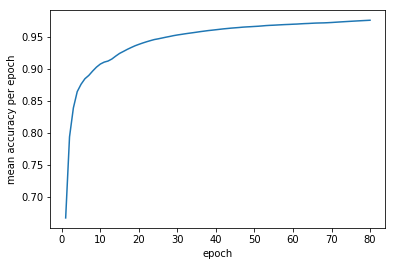

In [13]:
plt.plot(np.arange(1,epochs+1), train_acc_mean)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epoch')
plt.show()

In [14]:
# this part calculates the number of trainable parameters

model = HappyModel(learning_rate = learning_rate)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())

    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        print('shape of weight matrix: ',shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim.value
        print('number of trainable parameters: ',variable_parameters)
        print('------------------------------')
        total_parameters += variable_parameters
    print('total number of trainable parameters: ',total_parameters)

# this part calculates the number of all the  parameters
    total_parameters = 0
    for variable in tf.all_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    print('total number of parameters: ',total_parameters)

W0812 22:39:06.679410 30984 deprecation.py:323] From <ipython-input-14-011611f3bf71>:26: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


<tf.Variable 'conv0/kernel:0' shape=(7, 7, 3, 32) dtype=float32_ref>
shape of weight matrix:  (7, 7, 3, 32)
number of trainable parameters:  4704
------------------------------
<tf.Variable 'conv0/bias:0' shape=(32,) dtype=float32_ref>
shape of weight matrix:  (32,)
number of trainable parameters:  32
------------------------------
<tf.Variable 'bn0/gamma:0' shape=(32,) dtype=float32_ref>
shape of weight matrix:  (32,)
number of trainable parameters:  32
------------------------------
<tf.Variable 'bn0/beta:0' shape=(32,) dtype=float32_ref>
shape of weight matrix:  (32,)
number of trainable parameters:  32
------------------------------
<tf.Variable 'fully_connected/weights:0' shape=(32768, 1) dtype=float32_ref>
shape of weight matrix:  (32768, 1)
number of trainable parameters:  32768
------------------------------
<tf.Variable 'fully_connected/biases:0' shape=(1,) dtype=float32_ref>
shape of weight matrix:  (1,)
number of trainable parameters:  1
------------------------------
total 

## Testing

In [15]:
tf.reset_default_graph()
model = HappyModel(learning_rate = learning_rate)

test_acc = []
test_acc_v2 = []

with tf.Session(config=config) as sess: 
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sess.run(tf.local_variables_initializer())
    
    iteration = 1
    #for (x, y) in get_batches(X_test, Y_test, batch_size):
    for (x, y) in random_mini_batches(X_test, Y_test, mini_batch_size = mini_batch_size, seed = 0):
        feed = {model.inputs_: x,
                   model.targets_: y,
                   model.training: False}


        batch_loss, batch_accuracy, batch_acc, batch_acc_op = sess.run([model.loss, model.accuracy,
                                                                       model.acc, model.acc_op],
                                 feed_dict=feed)
            
        test_acc.append(batch_accuracy)
        test_acc_v2.append(batch_acc_op)
        
        if iteration%1==0:
            print("Iteration: {}".format(iteration),
                      "Test loss: {:.3f}".format(batch_loss),
                      "Test accuracy: {:.4f}".format(batch_acc_op)
                     )
                     
                
        iteration +=1

    print("Test accuracy (mean): {:.4f} ".format(np.mean(test_acc_v2)))

W0812 22:39:08.365504 30984 deprecation.py:323] From C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Iteration: 1 Test loss: 0.063 Test accuracy: 0.9375
Iteration: 2 Test loss: 0.001 Test accuracy: 0.9688
Iteration: 3 Test loss: 0.002 Test accuracy: 0.9792
Iteration: 4 Test loss: 0.000 Test accuracy: 0.9844
Iteration: 5 Test loss: 0.001 Test accuracy: 0.9875
Iteration: 6 Test loss: 0.362 Test accuracy: 0.9792
Iteration: 7 Test loss: 0.006 Test accuracy: 0.9821
Iteration: 8 Test loss: 0.562 Test accuracy: 0.9688
Iteration: 9 Test loss: 0.066 Test accuracy: 0.9653
Iteration: 10 Test loss: 0.000 Test accuracy: 0.9667
Test accuracy (mean): 0.9719 
